In [1]:
#make imports

import os
import sys
import pandas as pd
import numpy as np
import pickle
import re
import unicodedata
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud

In [2]:
#import headphones metadata and reviews in pandas dataframe

with open('headphone_meta_df.pkl', 'rb') as f:
    meta_df = pickle.load(f)

with open('headphone_review_df.pkl', 'rb') as f:
    review_df = pickle.load(f)

In [3]:
#print the number of rows and columns in metadata and reviews

print("the dimensions of the review dataframe are: ", review_df.shape)
print("the dimensions of the metadata dataframe are: ", meta_df.shape)

the dimensions of the review dataframe are:  (735, 12)
the dimensions of the metadata dataframe are:  (27396, 19)


In [4]:
print(review_df.columns)
print(meta_df.columns)

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')
Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')


In [5]:
#descriptive stats of the product

print("The number of reviews are: ", review_df.shape[0])
print("The average rating score is: ", review_df['overall'].mean())
print("The number of unique products are: ", len(review_df['asin'].unique()))
print("The number of good ratings are: ", review_df[review_df['overall'] >= 3].shape[0])
print("The number of bad ratings are: ", review_df[review_df['overall'] < 3].shape[0])
print("The number of reviews corresponding to each rating are: ", review_df['overall'].value_counts())

The number of reviews are:  735
The average rating score is:  3.379591836734694
The number of unique products are:  494
The number of good ratings are:  517
The number of bad ratings are:  218
The number of reviews corresponding to each rating are:  overall
5.0    231
4.0    162
1.0    127
3.0    124
2.0     91
Name: count, dtype: int64


In [6]:
acronyms_dict = {
    'lol': 'laugh out loud',
    'btw': 'by the way',
    'b4': 'before',
    'rofl': 'rolling on the floor laughing',
}

def preprocess_text(text):

    #remove the html tags
    text = re.sub(r'<.*?>', '', text)
    
    #remove accented characters
    #source: "https://guangyuwu.wordpress.com/2017/09/27/normalizing-unicode/"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    #expand acronyms
    for acronym, replacement in acronyms_dict.items():
        text = text.replace(acronym, replacement)

    #lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    #normalize the text
    text = text.lower()

    return text

In [7]:
#preprocess the review text and add as a new column in the review dataframe

review_df['processed_text'] = review_df['reviewText'].apply(preprocess_text)

In [8]:
print(review_df['processed_text'])

11677      i buy at least a couple pair of koss headphone...
12708      wow. for the price it pimp slap half the can i...
12815      lasted a little over a year. was expecting mor...
14041      amazing sound quality in such a portable desig...
14062      i've had these headphone for a couple month no...
                                 ...                        
6406100    these headphone are extremely flimsy. so flims...
6412066    i need over ear phone since my office mate i s...
6481656    i purchased this to view tv without disturbing...
6627772    i had read the review on these before i bought...
6716841    i consider myself an audiophile per-se, i love...
Name: processed_text, Length: 735, dtype: object


In [9]:
# To extract relevant statistics, perform the following EDA -
# a. Top 20 most reviewed brands in the category that you have chosen.
# b. Top 20 least reviewed brands in the category you have chosen.
# c. Which is the most positively reviewed ‘Headphone’ ( Or for any other
# electronic product you have selected)
# d. Show the count of ratings for the product over 5 consecutive years.
# e. Form a Word Cloud for ‘Good’ and ‘Bad’ ratings. Report the most
# commonly used words for positive and negative reviews by observing the
# good and bad word clouds.
# f. Plot a pie chart for Distribution of Ratings vs. the No. of Reviews.
# g. Report in which year the product got maximum reviews.
# h. Which year has the highest number of Customers?


# (a) and (b)
asin_count = review_df['asin'].value_counts().to_dict()

brand_count = defaultdict(int)
for asin in asin_count:
    brand = meta_df[meta_df['asin'] == asin]['brand'].values[0]
    brand_count[brand] += asin_count[asin]

brand_count = dict(sorted(brand_count.items(), key=lambda x: x[1], reverse=True))

print("The top 20 most reviewed brands are: ", list(brand_count.keys())[:20])
print("The top 20 least reviewed brands are: ", list(brand_count.keys())[-20:])


# (c) 
most_positively_reviewed_asin = review_df.groupby('asin')['overall'].mean().idxmax()
most_positively_reviewed_product = meta_df[meta_df['asin'] == most_positively_reviewed_asin]['title'].values[0]
print("The most positively reviewed product is: ", most_positively_reviewed_product)
print("\n\n\n")

# (d)

#count of ratings of the top3 most positively reviewed products in different years with their titles
review_df['reviewTime'] = pd.to_datetime(review_df['reviewTime'])
review_df['year'] = review_df['reviewTime'].dt.year

top3_most_positively_reviewed_asins = review_df.groupby('asin')['overall'].mean().nlargest(3).index
for asin in top3_most_positively_reviewed_asins:
    product_title = meta_df[meta_df['asin'] == asin]['title'].values[0]
    print("The count of ratings for the product ", product_title, " over 5 consecutive years are: ")
    print(review_df[review_df['asin'] == asin].groupby('year')['overall'].count())
print("\n\n\n")

# (e)

good_reviews = review_df[review_df['overall'] >= 3]['processed_text'].str.cat(sep=' ')
bad_reviews = review_df[review_df['overall'] < 3]['processed_text'].str.cat(sep=' ')

good_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(good_reviews)
bad_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(bad_reviews)

print("The most commonly used words for positive reviews are: ")
print(good_wordcloud.words_)

print("upon observation the most commonly used words for positive reviews are: sound, good, great, well, comfortable, fit")
print("\n\n\n")

print("The most commonly used words for negative reviews are: ")
print(bad_wordcloud.words_)

print("upon observation the most commonly used words for negative reviews are: use, even, work, look, back, still")
print("\n\n\n")

The top 20 most reviewed brands are:  ['Sony', 'Sennheiser', 'Bose', 'V-MODA', 'beyerdynamic', 'Koss', 'Audio-Technica', 'Beats', 'Bluedio', 'Panasonic', 'MEE audio', 'JVC', 'Creative', 'EldHus', 'BRAINWAVZ', 'SMS Audio', 'Symphonized', 'Avantree', 'Jaybird', 'JBL']
The top 20 least reviewed brands are:  ['Jarv', 'Rokit Boost', 'White Label', 'Pioneer', 'HiFiMAn Electronics', 'CAD Audio', 'iLuv', 'Motorheadphones', 'It is', 'Gedun', 'Adventure Time', 'Tascam', 'Griffin Technology', 'Sentry Industries Inc.', 'Noontec', 'DAEETO', 'Seotic', 'Just Mobile', 'Aecoke', 'Audeze']
The most positively reviewed product is:  Koss SportaPro Stereo Headphones




The count of ratings for the product  Koss SportaPro Stereo Headphones  over 5 consecutive years are: 
year
2017    1
Name: overall, dtype: int64
The count of ratings for the product  Sennheiser HD 600 Open Back Professional Headphone  over 5 consecutive years are: 
year
2015    2
2016    1
Name: overall, dtype: int64
The count of ratings f

The distribution of ratings vs the number of reviews is: 


<Axes: ylabel='count'>

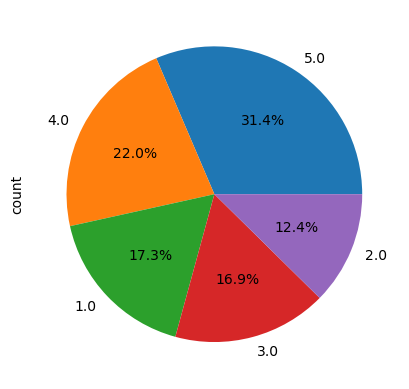

In [10]:
# (f)

rating_distribution = review_df['overall'].value_counts()
print("The distribution of ratings vs the number of reviews is: ")
rating_distribution.plot.pie(autopct='%1.1f%%')

In [11]:
# (g)
print("The year in which the most positively reviewed product got maximum reviews is: ", review_df[review_df['asin'] == most_positively_reviewed_asin]['year'].value_counts().idxmax())

# (h)
print("The year with the highest number of customers is: ", review_df['year'].value_counts().idxmax())

The year in which the most positively reviewed product got maximum reviews is:  2017
The year with the highest number of customers is:  2015
